In [30]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from prophet import Prophet
import datetime as dt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import ipywidgets as widgets 
from IPython.display import display

# https://voila.readthedocs.io/en/stable/using.html

In [32]:
#Run Voila
#voila Presentation_Demo.ipynb

In [34]:
# Load data
a_path = Path("Resources/world_population_data.csv")
b_path = Path("Resources/Production_Crops_Livestock_E_All_Data.csv")
c_path = Path("Resources/API_SP.POP.TOTL_DS2_en_csv_v2_3401680.csv")
d_path = Path("Resources/Lists_test.csv")
world_population = pd.read_csv(a_path)
agri_data = pd.read_csv(b_path, encoding='ISO-8859-1', low_memory = False)
world_population_all_years = pd.read_csv(c_path)
category_ag_data = pd.read_csv(d_path)

In [35]:
# Options for dropdown menu
options = ['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania']
options2 = ['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar',
       'Vegetable']
options3= ['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Caucasia', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Cook Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Grenada', 'Guadeloupe', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar',
       'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta',
       'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius',
       'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique',
       'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'New Caledonia',
       'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palestine',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Romania', 'Rwanda',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Samoa',
       'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia',
       'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan',
       'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland',
       'Tajikistan', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau',
       'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkmenistan',
       'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates',
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Yemen',
       'Zambia', 'Zimbabwe', 'Micronesia']

In [36]:
# Create dropdowns
continent_dropdown = widgets.Dropdown(options=options, value=options[0], description='Continent')
category_dropdown = widgets.Dropdown(options=options2, value=options2[0], description='Category')
country_dropdown = widgets.Dropdown(options=options3, value=options3[0], description='Country')
# Display dropdown menus
# display(continent_dropdown, country_dropdown, category_dropdown)

In [37]:
#Drop columns that are not needed
columns_to_drop =["Area Code", "Area Code (M49)", "Item Code", "Item Code (CPC)", "Element Code", "Element"]
agri_data.drop(columns=columns_to_drop, inplace=True)

# Rename Area to Country
agri_data = agri_data.rename(columns={"Area": "Country"})

#Remove Y from year
agri_data.columns = agri_data.columns.str.replace("Y", "")



In [38]:
# remove columns that do not hold numerical example 1962F and 1962N 
columns_to_drop2 = [col for col in agri_data.columns if col.endswith('F') or col.endswith('N')]
df_cleaned = agri_data.drop(columns=columns_to_drop2)


In [42]:
# Make category_ag_data.set a dictionary and set index
group_mapping = category_ag_data.set_index('Item')['Category'].to_dict()

In [46]:
# Create a new column named 'Category' in df based on 'Item' defined in group_mapping
df_cleaned['Category'] = df_cleaned['Item'].replace(group_mapping)

In [48]:
# Filter Units column for Tonnes, Animals or 1000 Animals
filtered_df = df_cleaned[df_cleaned['Unit'].isin(['t', 'An', '1000 An'])]

# Filter out items that do have assigned categories
categories_to_keep = ['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar', 'Vegetable']
filtered_df = filtered_df[filtered_df['Category'].isin(categories_to_keep)]

#Re-order Dataframe
columns = filtered_df.columns.tolist()
category_index = columns.index('Category')
columns.insert(2, columns.pop(category_index))
ag_df = filtered_df[columns]


In [50]:
# Convert 1000 An to An so that all animals can be combined using same values
# Identify rows with '1000 An' in the 'Unit' column
multiply_by = ag_df['Unit'] == '1000 An'

# Multiply the values by 1000 where 'Unit' is '1000 An'
ag_df.loc[multiply_by, ag_df.columns[4:]] = ag_df.loc[multiply_by, ag_df.columns[4:]].multiply(1000)

# Use .loc to replace '1000 An' with 'An' in the 'Unit' column
ag_df.loc[ag_df['Unit'] == '1000 An', 'Unit'] = 'An'

# Display DF


In [52]:
#Add 'Continent' column to ag_df, by merging world_popultion dataset
columns_to_drop2 =["2023 population", "cca3", "2022 population", "2020 population", "2015 population", "2010 population", "2000 population", "1990 population", "1980 population", "1970 population"]
world_population.drop(columns=columns_to_drop2, inplace=True)
world_population.rename(columns={"country": "Country", "continent": "Continent"}, inplace=True)

# Create new df, for this merge and keep world_population for later use below
wp_for_merge = world_population.copy()
columns_to_drop3 =["rank", "area (km²)", "density (km²)", "growth rate", "world percentage"]
wp_for_merge.drop(columns=columns_to_drop3, inplace=True)

# Merge Dataset using inner 
ag_df_fnl = pd.merge(ag_df, wp_for_merge, on= "Country", how="inner")

#Re-order Dataframe
columns = ag_df_fnl.columns.tolist()
category_index = columns.index('Continent')
columns.insert(1, columns.pop(category_index))
ag_df_fnl = ag_df_fnl[columns]

# Filter out rows where 'Unit' is 'An' and 'Category' is not 'Meat'
ag_df_fnl = ag_df_fnl.drop(ag_df_fnl[(ag_df_fnl['Unit'] == 'An') & (ag_df_fnl['Category'] != 'Meat')].index)

# Display DF


In [144]:
# # Display dropdown menu
display(country_dropdown)
display(category_dropdown)

Dropdown(description='Country:', index=32, options=('Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua an…

Dropdown(description='Category:', index=2, options=('Nut', 'Fruit', 'Meat', 'Grain', 'Dairy', 'Eggs', 'Honey',…

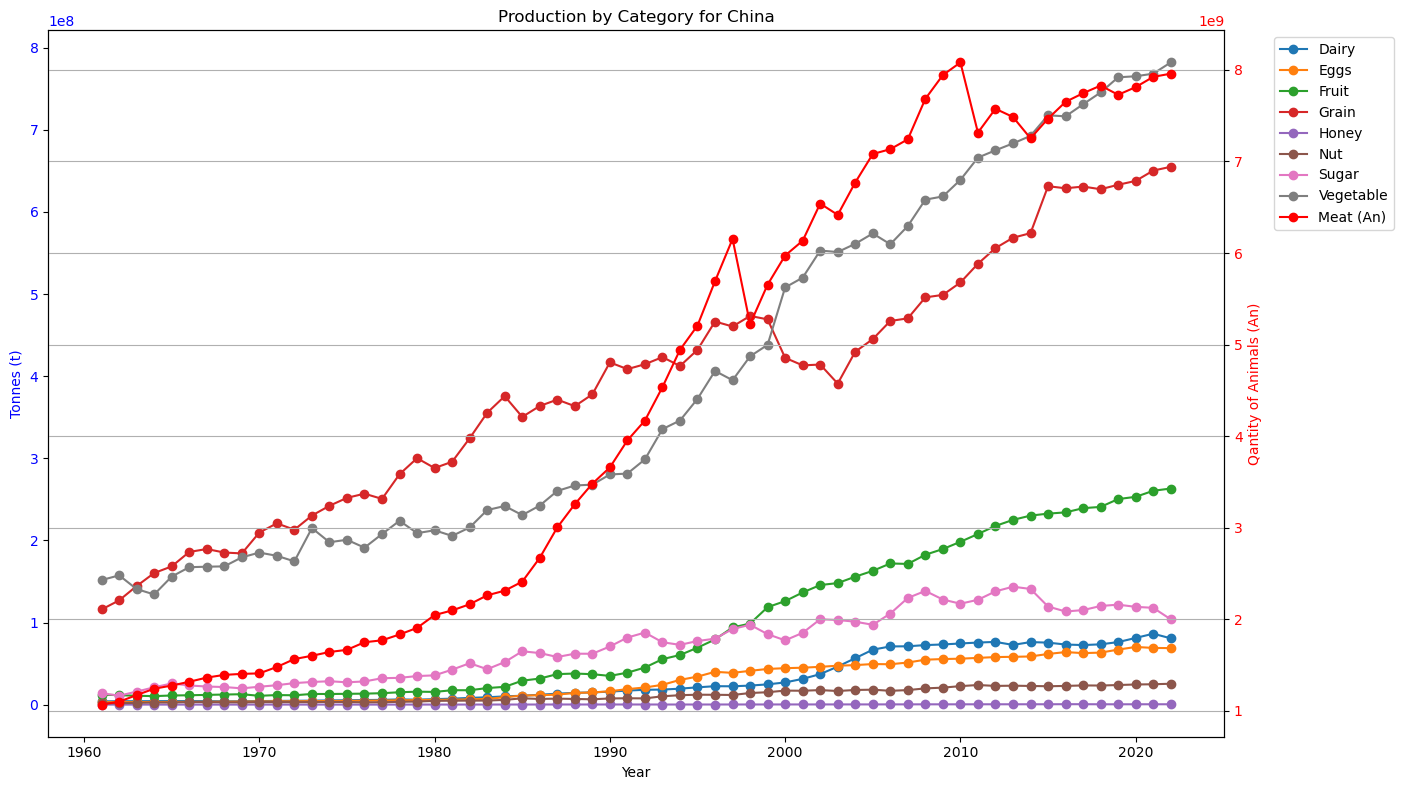

In [146]:
# Let User Select a Country , and display categories

# Filter the data for Selected Counrty
selected_country = country_dropdown.value # This would be another good place for a drop down

# Filter the dataset for the selected category and unit
country_df = ag_df_fnl[(ag_df_fnl['Country'] == selected_country)]

# Group by Country, Category, and Year and sum the production values
grouped_df = country_df.groupby(['Country', 'Category']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Country', 'Category'], 
                value_vars=[str(year) for year in range(1961, 2023)],
                var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each category as a separate line
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot categories with unit 't' on the first y-axis (ax1)
for category in melted_df[melted_df['Category'] != 'Meat']['Category'].unique():
    data = melted_df[(melted_df['Category'] == category) & (melted_df['Value'] != 'An')]
    ax1.plot(data['Year'], data['Value'], marker='o', label=category)

# Set labels and title for the first y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Tonnes (t)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis (ax2) for the category with unit 'An'
ax2 = ax1.twinx()
meat_data = melted_df[melted_df['Category'] == 'Meat']
ax2.plot(meat_data['Year'], meat_data['Value'], marker='o', color='red', label='Meat (An)')
ax2.set_ylabel('Qantity of Animals (An)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
    
    # Adding labels and title
plt.title(f'Production by Category for {selected_country}')
plt.grid(True)
    
    # Display legend for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor = (1.15, 1))
    
    # Show the plot
plt.tight_layout()
plt.show()

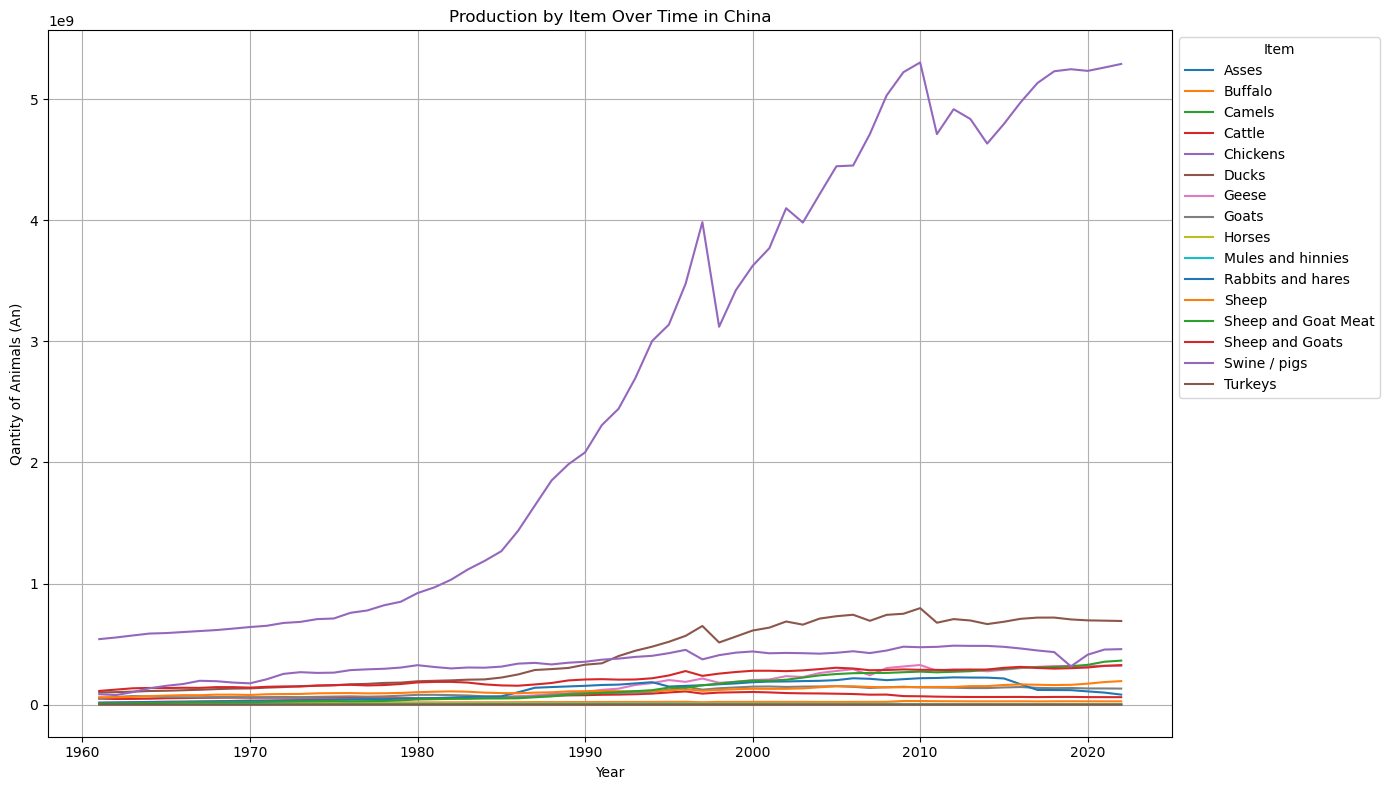

In [148]:
# Let User Select a Category, display Items vs time in graph


# Filter the data for the Category

selected_category = category_dropdown.value #Another good spot for dropdown menu

# Check the selected category and set the unit accordingly
if selected_category == 'Meat':
    selected_unit = 'An'
else:
    selected_unit = 't'

# Filter the dataset for the selected country, category, and unit
country_category_df = ag_df_fnl[
    (ag_df_fnl['Country'] == selected_country) &
    (ag_df_fnl['Category'] == selected_category) &
    (ag_df_fnl['Unit'] == selected_unit)  
]

# Group by Item and Year and sum the production values
grouped_item_df = country_category_df.groupby(['Item']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df, 
    id_vars=['Item'], 
    value_vars=[str(year) for year in range(1961, 2023)], 
    var_name='Year', 
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Qantity of Animals (An)'
else:
    y_label = f'Tonnes of {selected_category}'
    
plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Production by Item Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left',bbox_to_anchor = (1, 1))

# Show the plot
plt.tight_layout()
plt.show()

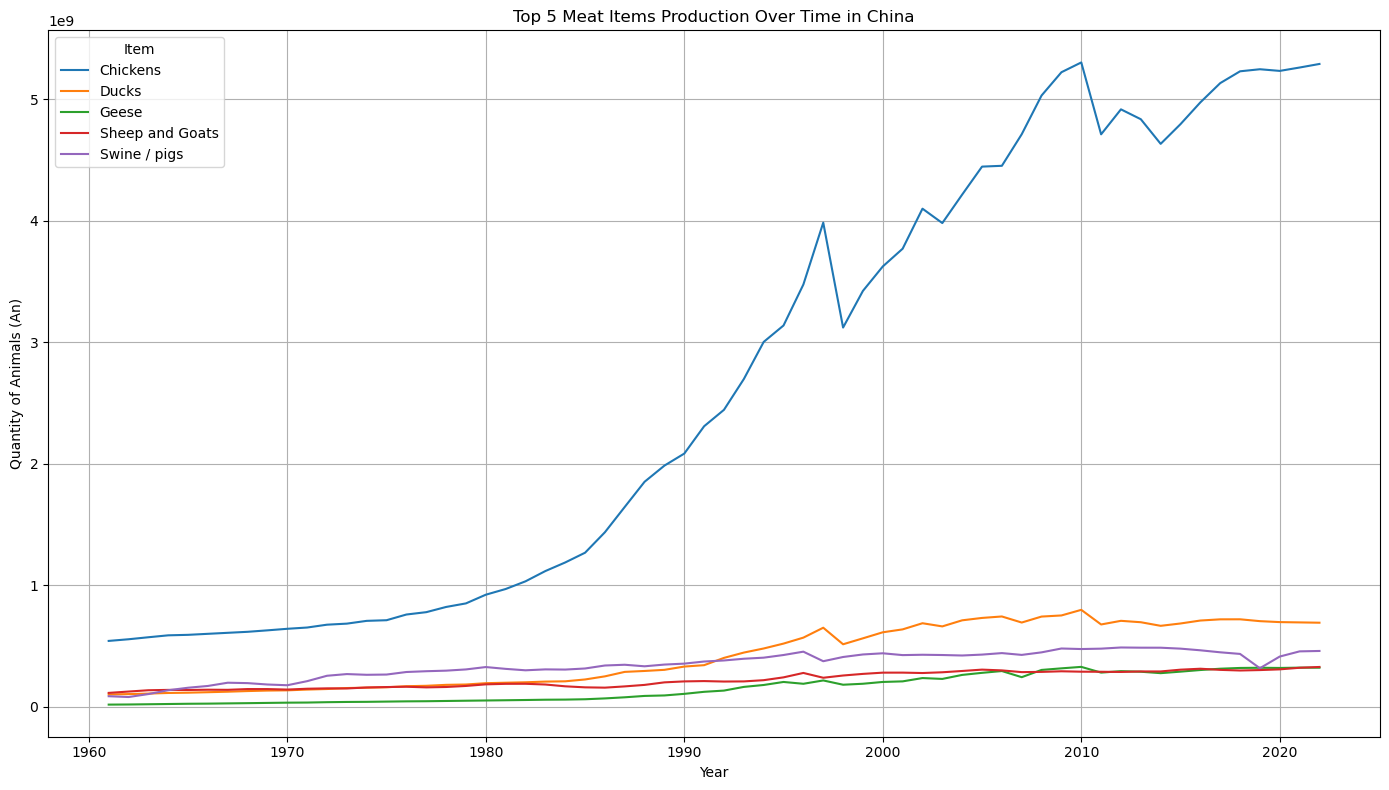

In [152]:
# Filter the data for top 5 of selected 'Category' for selected 'Country'

# Calculate the total production for each item and select the top 5 items
grouped_item_df['Total_Production'] = grouped_item_df[
    [str(year) for year in range(1961, 2023)]
].sum(axis=1)

# Get the top 5 items based on total production
top_items = grouped_item_df.nlargest(5, 'Total_Production')['Item'].tolist()

# Filter the data to include only the top 5 items
grouped_item_df = grouped_item_df[grouped_item_df['Item'].isin(top_items)]

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df,
    id_vars=['Item'],
    value_vars=[str(year) for year in range(1961, 2023)],
    var_name='Year',
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Quantity of Animals (An)'
else:
    y_label = f'Tonnes of {selected_category}'

plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Top 5 {selected_category} Items Production Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
